# Import packages

In [71]:
import os
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Generate Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset includes 20 players who played the most 600+0 games in July 2023. This dataset contains "lichess annotated" games they played.

In [72]:
df = pd.read_csv("/content/drive/MyDrive/600+0_top20.csv")

I chose 5 random players among the top 20 players.

In [73]:
df_player = df.groupby(['Player', 'GameIndex']).first().reset_index()
df_player = df_player.groupby(["Player"]).size().reset_index(name='count')
df_player = df_player[['Player', 'count']]
df_player.columns = ["player", "count"]
df_player = df_player.sort_values(by = ["count"], ascending = False)
p_list = list(df_player["player"])
p_list = random.sample(p_list, 5)

In [74]:
df = df[(df['Player'].isin(p_list))]

In [75]:
df_player[df_player['player'].isin(p_list)]

,player,count
1,2,485
2,3,443
5,6,390
16,17,329
17,18,325


In [76]:
df_ts = df.groupby(['GameIndex', 'Player', 'Time'])['TimeSpent'].max().reset_index()
df_ts = df_ts.sort_values(by = ['GameIndex', 'Time'], ascending = False)

In [77]:
df_prev = df_ts

In [78]:
df_ts = df_ts.pivot_table(values = 'TimeSpent', index = ['GameIndex', 'Player'], columns = 'Time', aggfunc = 'first')
df_ts = df_ts.fillna(0)

In [79]:
df_ts = df_ts.reset_index()

In [80]:
df_ts_y = df_ts[['GameIndex', 'Player']]
df_ts_x = df_ts.drop(columns = ['GameIndex', 'Player'])

# Analysis

In [94]:
df_ts = df_ts.sample(n = 100)

If you haven't installed tslearn, you can install here.

In [ ]:
!pip install tslearn

In [92]:
from tslearn.preprocessing import TimeSeriesScalerMinMax
df_ts_x = df_ts.drop(columns = ['GameIndex', 'Player'])
df_ts_y = df_ts[['GameIndex', 'Player']]
scaler = TimeSeriesScalerMinMax(value_range=(0., 1.))
df_ts_x_scaled = scaler.fit_transform(df_ts_x)

You can tune the hyperparameters

In [95]:
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters= 5, metric = "dtw",
                      max_iter = 5, max_iter_barycenter = 5,
                      verbose=False, random_state=42)
y_pred = km.fit_predict(df_ts_x_scaled)

In [96]:
km.inertia_

0.49900776043872896

In [97]:
df_ts_y['category'] = y_pred

In [98]:
y_graph = df_ts_y.groupby(['Player', 'category'])['category'].count().reset_index(name='counts')

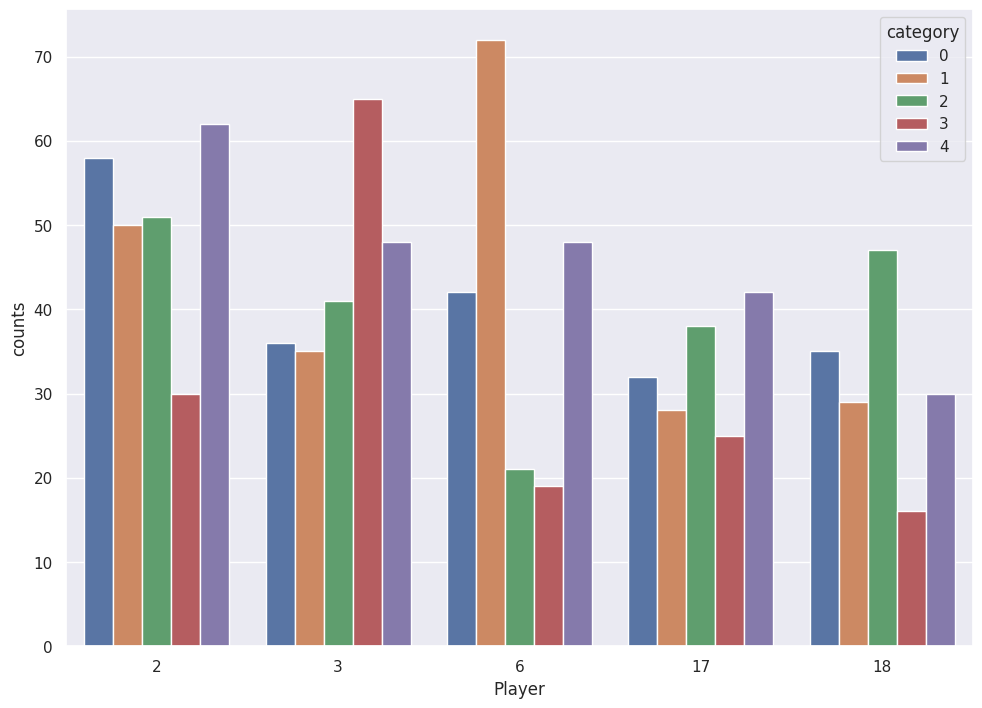

In [99]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = y_graph, x = "Player", y = 'counts', hue = 'category')
plt.show()

In [100]:
df_ts_graph = df_prev[df_prev.GameIndex.isin(list(df_ts_y['GameIndex']))]
df_ts_graph = pd.merge(df_ts_graph, df_ts_y, on = ['GameIndex', 'Player'])

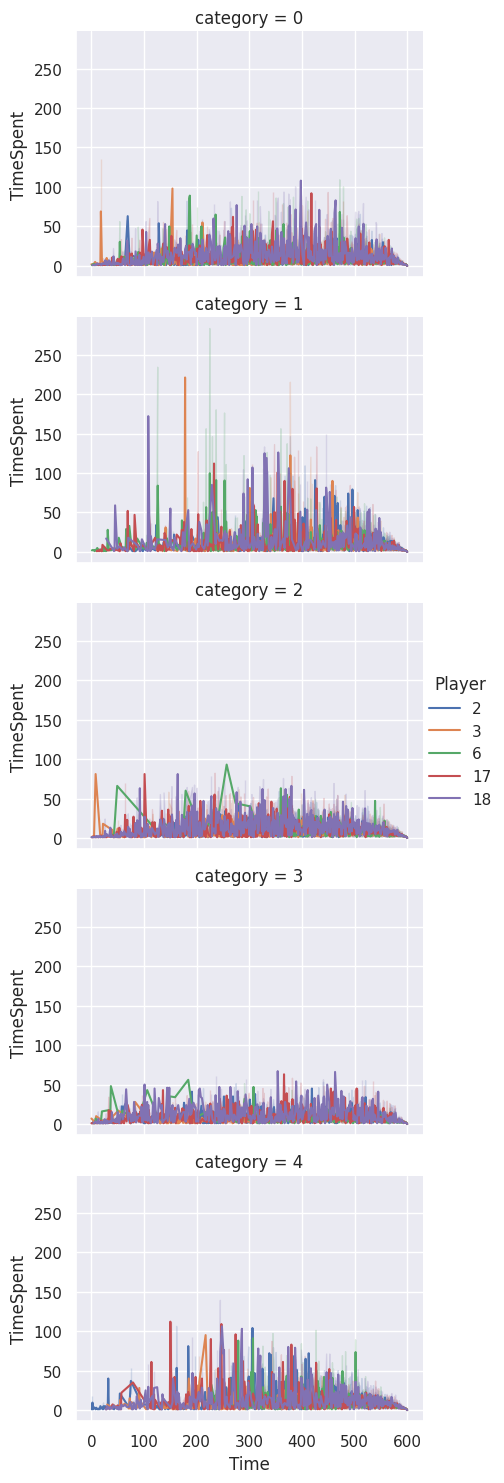

In [101]:
sns.color_palette("Set2")
g = sns.FacetGrid(df_ts_graph, row = 'category', hue = "Player",
                  height = 3, aspect = 1.5)
g.map_dataframe(sns.lineplot, x = "Time", y = "TimeSpent")
g.add_legend()
plt.show()

In [102]:
df_ts_y.groupby(['category'])['category'].count()

category
0    203
1    214
2    198
3    155
4    230
Name: category, dtype: int64